In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy.linalg as la
from mpl_toolkits import mplot3d
from scipy import stats
import datetime as dt
import statsmodels.api as sm
from scipy.optimize import curve_fit

In [3]:
# Import SIE data
directory = Path('Sea Ice')

files = [file_name for file_name in os.listdir(directory) if file_name.endswith('.csv')]

SIE_N = pd.DataFrame(columns=['year','mo','extent'])
SIE_S = pd.DataFrame(columns=['year','mo','extent'])

# Import SIE for North and South
for indx,file in enumerate(files):
    path_to_file = os.path.join(directory, file)
    data_file = pd.read_csv(path_to_file) 
    data_file.columns = data_file.columns.str.strip()
    if (data_file['region'].str.strip() == 'N').all() == True:
        SIE_N = pd.concat([SIE_N, data_file[['year','mo','extent']]])
    elif (data_file['region'].str.strip() == 'S').all() == True:
        SIE_S = pd.concat([SIE_S, data_file[['year','mo', 'extent']]]) 
        

# Put in chronological order
SIE_N = SIE_N.sort_values(['year','mo']).iloc[2:]
SIE_S = SIE_S.sort_values(['year','mo']).iloc[2:]


# Substitute -9999 values for NaN
SIE_N['extent'] = SIE_N['extent'].mask(SIE_N['extent'] < SIE_N['extent'].quantile(0.01))
SIE_S['extent'] = SIE_S['extent'].mask(SIE_S['extent'] < SIE_S['extent'].quantile(0.01))

(4.0, 17.0)

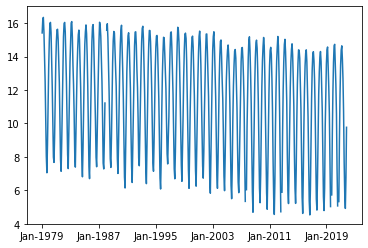

In [4]:
# create date array for plotting
date=np.array(pd.date_range('1979-01-01','2021-11-01', freq='MS').strftime("%b-%Y").tolist())
# Plot SIE_N
plt.plot(date,np.array(SIE_N['extent']))
locs, labels = plt.xticks()
plt.xticks(np.arange(0, len(date)+1, 96))
plt.ylim([4,17])

In [5]:
# Import Temperature Data
directory = Path('Temperature')

files = [file_name for file_name in os.listdir(directory) if file_name.endswith('.csv')]
file = files[0]
path_to_file = os.path.join(directory, file)
data_file = pd.read_csv(path_to_file) 
data_file.columns = data_file.columns.str.strip()
T = data_file.iloc[1979-1880:, 1:13]

# Put values in chronological order in a flat list
T_all = T.values.tolist()
T_flat = [item for sublist in T_all for item in sublist]
T_flat = T_flat[0:-1]
T_flat = [float(i) for i in T_flat]

([<matplotlib.axis.XTick at 0x2d3f3a39eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

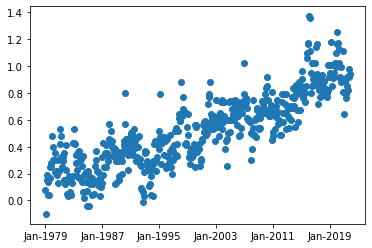

In [6]:
# Plot Temperature
t = np.linspace(0,len(T_flat)-1,len(T_flat))
plt.scatter(date,T_flat)
plt.xticks(np.arange(0, len(date)+1, 96))

r: -0.09316776847202718


Text(0.5, 0, 'Temperature')

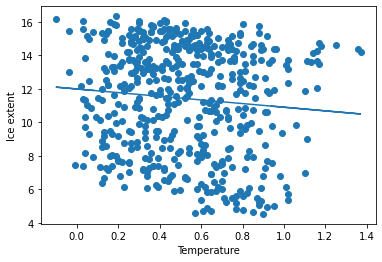

In [7]:
# Doing all the data points yields very bad r
SIEN_extent = np.array(SIE_N['extent'])
T_flat0 = np.array(T_flat)
valid = ~(np.isnan(T_flat0) | np.isnan(SIEN_extent))
m, b, r, p, std_err = stats.linregress(T_flat0[valid], SIEN_extent[valid])
print('r:', r)
plt.scatter(T_flat0, SIEN_extent)
plt.plot(T_flat0, m*T_flat0+b)
plt.ylabel('Ice extent')
plt.xlabel('Temperature')

r: 0.17739636015434437
SEr: 4.887083076252532
r-SEr -4.7096867160981875
r+SEr 5.064479436406876


Text(0.5, 0, 'Temperature')

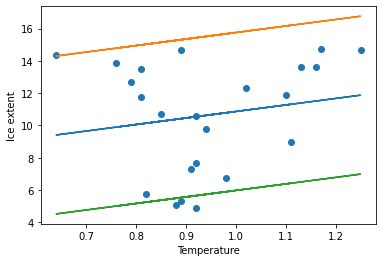

In [8]:
# Doing single year windows yields higher values of 'r' but not statistical significance
# This makes sense, as we are looking at the relation between anomalies across one year and the 
# respective sea ice variation across the months. However, anomalies will be similar throughout 
# a year, so we just expect multiple dots of different y values over a very small range of x values.

SIEN_extent = np.array(SIE_N['extent'])[-24:]
T_flat0 = np.array(T_flat)[-24:]
valid = ~(np.isnan(T_flat0) | np.isnan(SIEN_extent))
m, b, r, p, std_err = stats.linregress(T_flat0[valid], SIEN_extent[valid])
print('r:', r)
print('SEr:', std_err)
print('r-SEr',r-std_err)
print('r+SEr',r+std_err)
plt.scatter(T_flat0, SIEN_extent)
plt.plot(T_flat0, m*T_flat0+b)
plt.plot(T_flat0, m*T_flat0+b+std_err)
plt.plot(T_flat0, m*T_flat0+b-std_err)
plt.ylabel('Ice extent')
plt.xlabel('Temperature')

r: 0.8644310608625985
SEr: 4.589048881067267
r: 0.15016472414702356
SEr: 13.204355118904495
r: 0.10233786771430052
SEr: 15.613500807544192
r: 0.6686514680334987
SEr: 6.032775110941931
r: 0.7182275968695521
SEr: 4.111394958360843
r: -0.10072959083958923
SEr: 9.415438736984523
r: -0.2740041747576458
SEr: 9.673744149337121
r: -0.4362313649974581
SEr: 11.097221937836867


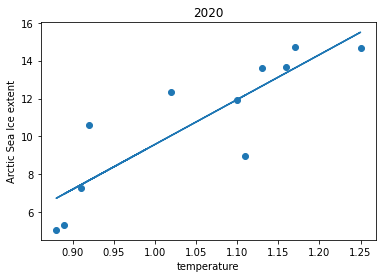

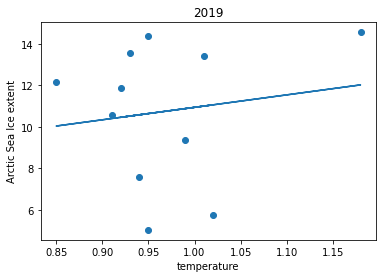

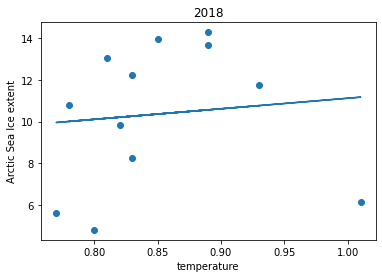

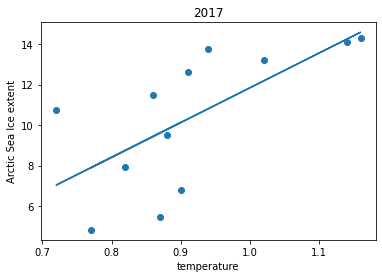

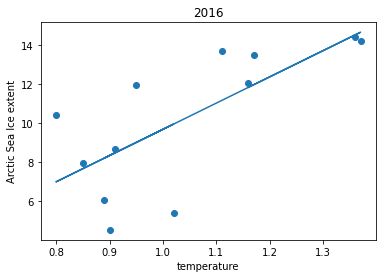

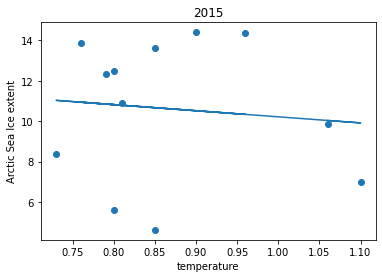

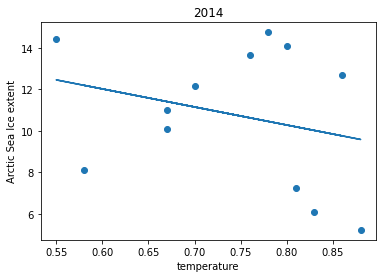

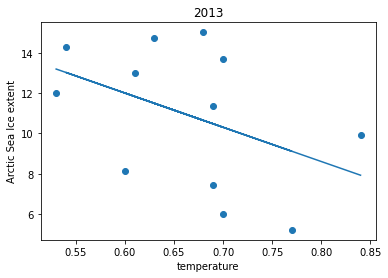

In [9]:
# Doing single year windows over the past 9 years
# Confirms hypothesis above
L=10
years = ['2013','2014','2015','2016','2017','2018','2019','2020','2021']
for l in range(2, L):
    SIEN_extent = np.array(SIE_N['extent'])[-l*12:-(l-1)*12]
    T_flat0 = np.array(T_flat)[-l*12:-(l-1)*12]
    valid = ~(np.isnan(T_flat0) | np.isnan(SIEN_extent))
    m, b, r, p, std_err = stats.linregress(T_flat0[valid], SIEN_extent[valid])
    print('r:', r)
    print('SEr:', std_err)
    plt.figure()
    plt.scatter(T_flat0, SIEN_extent)
    plt.plot(T_flat0, m*T_flat0+b)
    plt.xlabel('temperature')
    plt.ylabel('Arctic Sea Ice extent')
    plt.title(years[-l])

r: -0.8725074942575063
SEr: 0.19682346165605952
r-SEr -1.0693309559135658
r+SEr -0.6756840326014468


Text(0.5, 0, 'Temperature')

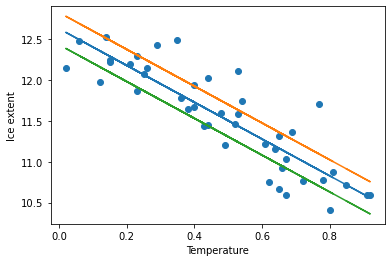

In [10]:
# Doing same month throught the years leads to statistical significance
SIEN_extent = np.array(SIE_N['extent'])[5::12]
T_flat0 = np.array(T_flat)[5::12]
valid = ~(np.isnan(T_flat0) | np.isnan(SIEN_extent))
m, b, r, p, std_err = stats.linregress(T_flat0[valid], SIEN_extent[valid])
print('r:', r)
print('SEr:', std_err)
print('r-SEr',r-std_err)
print('r+SEr',r+std_err)
plt.scatter(T_flat0, SIEN_extent)
plt.plot(T_flat0, m*T_flat0+b)
plt.plot(T_flat0, m*T_flat0+b+std_err)
plt.plot(T_flat0, m*T_flat0+b-std_err)
plt.ylabel('Ice extent')
plt.xlabel('Temperature')

r: -0.7531819168364879
SEr: 0.22094200368599023
r: -0.658914371243556
SEr: 0.231094453515342
r: -0.7647157959752541
SEr: 0.1867874687764928
r: -0.8207605879660878
SEr: 0.18702402278290373
r: -0.7701256213770242
SEr: 0.2042971655823122
r: -0.8725074942575063
SEr: 0.19682346165605952
r: -0.8713041375652564
SEr: 0.2931264934080909
r: -0.8370676034399455
SEr: 0.3435450245328443
r: -0.842206400131262
SEr: 0.3439928076428436
r: -0.8733250248624405
SEr: 0.2982139272239105
r: -0.8673865401764733
SEr: 0.18942732939267853
r: -0.7536050351666872
SEr: 0.23835467369393062


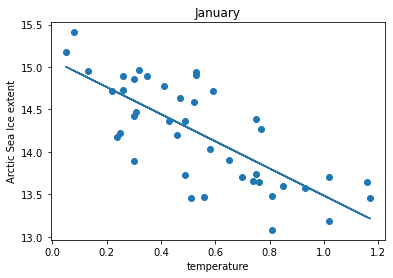

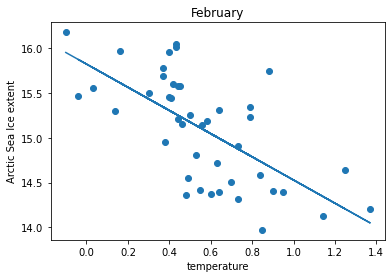

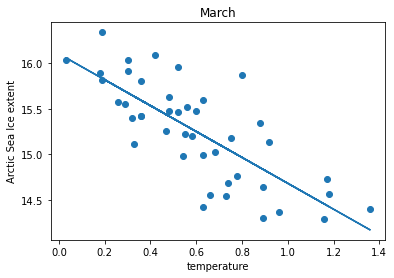

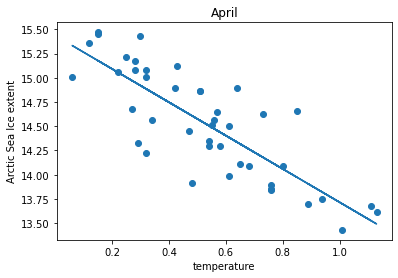

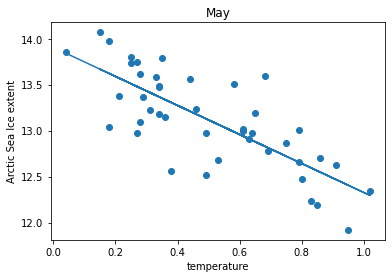

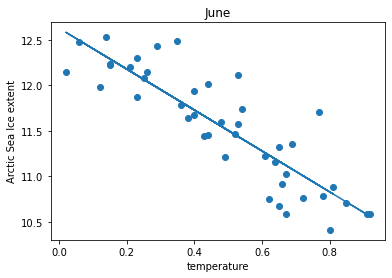

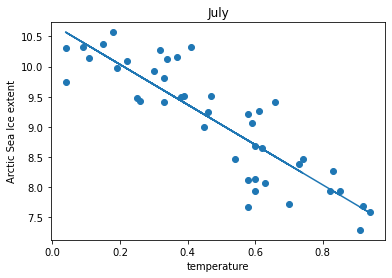

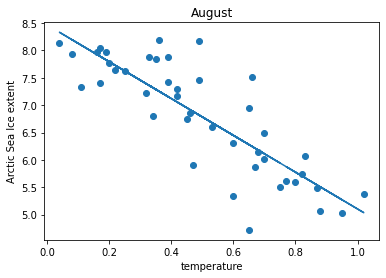

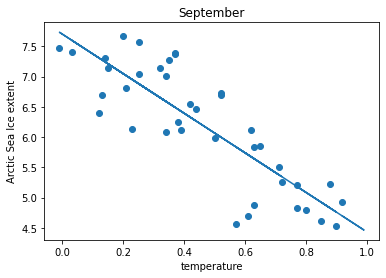

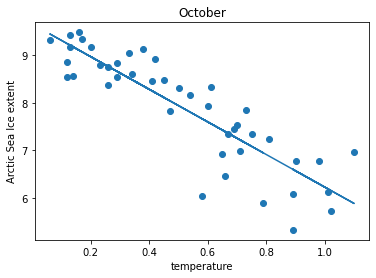

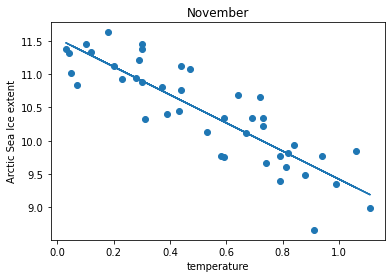

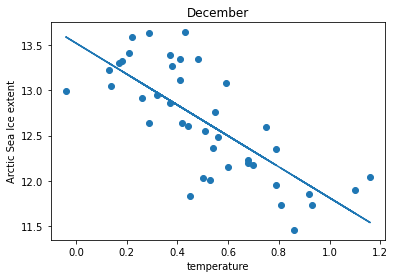

In [11]:
# Doing same month throught the years for every month 
L=12
import calendar
month=calendar.month_name
for l in range(0, L):
    SIEN_extent = np.array(SIE_N['extent'])[l::12]
    T_flat0 = np.array(T_flat)[l::12]
    valid = ~(np.isnan(T_flat0) | np.isnan(SIEN_extent))
    m, b, r, p, std_err = stats.linregress(T_flat0[valid], SIEN_extent[valid])
    print('r:', r)
    print('SEr:', std_err)
    plt.figure()
    plt.scatter(T_flat0, SIEN_extent)
    plt.plot(T_flat0, m*T_flat0+b)
    plt.xlabel('temperature')
    plt.ylabel('Arctic Sea Ice extent')
    plt.title(month[l+1])

42.916666666666664
[1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991.
 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003.
 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.
 2016. 2017. 2018. 2019. 2020. 2021.]
r: -0.9237706329627473
SEr: 0.17793063365069706
m: 0.018800606938409542


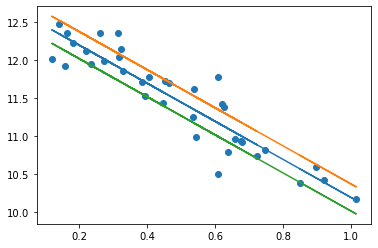

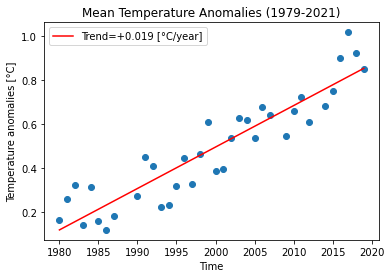

In [67]:
# Looking at mean anomaly per year
# Number of years
print(len(T_flat)/12)



L=42



T_Mean=[]
SIEN_extent_Mean=[]
date_Mean_clean=[]
date_Mean = np.linspace(1980,2021,42)
print(date_Mean)
for l in range(0, L):
    SIEN_extent = np.array(SIE_N['extent'])[l*12:(l+1)*12]
    SIEN_extent_mean = np.mean(SIEN_extent)
    T_flat0 = np.array(T_flat)[l*12:(l+1)*12]
    T_mean = np.mean(T_flat0)
    year=date_Mean[l]
    valid = ~(np.isnan(T_mean) | np.isnan(SIEN_extent_mean))
    T_Mean.extend(T_mean[valid])
    SIEN_extent_Mean.extend(SIEN_extent_mean[valid])
    date_Mean_clean.extend(year[valid])



m, b, r, p, std_err = stats.linregress(T_Mean, SIEN_extent_Mean)
print('r:', r)
print('SEr:', std_err)
plt.figure()
plt.scatter(T_Mean, SIEN_extent_Mean)
plt.plot(T_Mean, m*np.array(T_Mean)+b)
plt.plot(T_Mean, m*np.array(T_Mean)+b+std_err)
plt.plot(T_Mean, m*np.array(T_Mean)+b-std_err)



m, b, r, p, std_err = stats.linregress(date_Mean_clean, T_Mean)
print('m:', m)
plt.figure()
plt.scatter(date_Mean_clean,T_Mean)
plt.plot(date_Mean_clean, m*np.array(date_Mean_clean)+b,'r',label='Trend=+0.019 [°C/year]')
plt.ylabel('Temperature anomalies [°C]')
plt.xlabel('Time')
plt.title('Mean Temperature Anomalies (1979-2021)')
plt.legend()

In [13]:
# Import AO Data
directory = Path('AO')
path_to_file = os.path.join(directory, 'AO_data.txt')
data_file = pd.read_csv(path_to_file, sep="\s+") 
data_file.columns = data_file.columns.str.strip()
AO = data_file.iloc[29:, :]

AO_all = AO.values.tolist()
AO_flat = [item for sublist in AO_all for item in sublist]
AO_flat = AO_flat[0:-1]


r: 0.058197349000121995
SEr: 0.08590582848002559


Text(0.5, 0, 'AO')

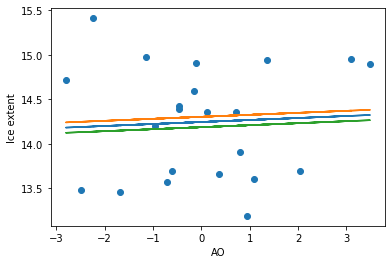

In [14]:
# Doing same month throught the years
SIEN_extent = np.array(SIE_N['extent'])[0::24]
AO_flat0 = np.array(AO_flat)[0::24]
valid = ~(np.isnan(AO_flat0) | np.isnan(SIEN_extent))
m, b, r, p, std_err = stats.linregress(AO_flat0[valid], SIEN_extent[valid])
print('r:', r)
print('SEr:', std_err)
plt.scatter(AO_flat0, SIEN_extent)
plt.plot(AO_flat0, m*AO_flat0+b)
plt.plot(AO_flat0, m*AO_flat0+b+r)
plt.plot(AO_flat0, m*AO_flat0+b-r)
plt.ylabel('Ice extent')
plt.xlabel('AO')

r: 0.039496551485764635
515 515


Text(0.5, 0, 'AO')

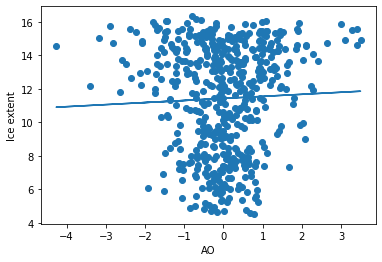

In [15]:
# Doing all the data points yields very bad r
SIEN_extent = np.array(SIE_N['extent'])
AO_flat0 = np.array(AO_flat)
valid = ~(np.isnan(AO_flat0) | np.isnan(SIEN_extent))
m, b, r, p, std_err = stats.linregress(AO_flat0[valid], SIEN_extent[valid])
print('r:', r)
print(len(AO_flat0), len(SIEN_extent))
plt.scatter(AO_flat0, SIEN_extent)
plt.plot(AO_flat0, m*AO_flat0+b)
plt.ylabel('Ice extent')
plt.xlabel('AO')


In [16]:
# Import AAO Data
directory = Path('AAO')
file = 'AAO_data.txt'
path_to_file = os.path.join(directory, file)
data_file = pd.read_csv(path_to_file, sep='\s+')
data_file.columns = data_file.columns.str.strip()

# Put values in chronological order in a flat list
AAO = data_file.values.tolist()
AAO_flat = [item for sublist in AAO for item in sublist]
AAO_flat = AAO_flat[:-1]

Text(0, 0.5, 'antarctic oscillation')

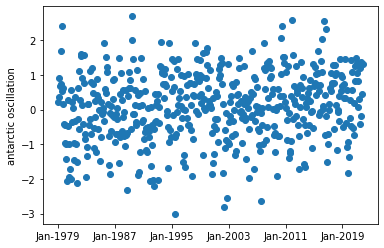

In [17]:
# Plot AAO
t = np.linspace(0,len(AAO_flat)-1,len(AAO_flat))
plt.scatter(date,AAO_flat)
plt.xticks(np.arange(0, len(date)+1, 96))
plt.ylabel('antarctic oscillation')

r: -0.025045763451550643


Text(0.5, 1.0, 'all data')

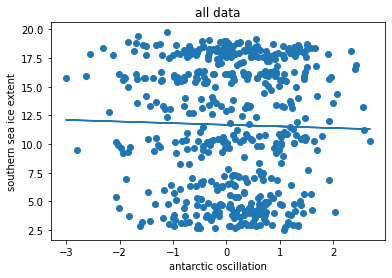

In [18]:
#Plotting all the data for each month for AAO
SIES_extent = np.array(SIE_S['extent'])
AAO_flat0 = np.array(AAO_flat)
valid = ~(np.isnan(AAO_flat0) | np.isnan(SIES_extent))
m, b, r, p, std_err = stats.linregress(AAO_flat0[valid], SIES_extent[valid])
print('r:', r)
plt.scatter(AAO_flat0, SIES_extent)
plt.plot(AAO_flat0, m*AAO_flat0+b)
plt.xlabel('antarctic oscillation')
plt.ylabel('southern sea ice extent')
plt.title('all data')

r: 0.32568932035568554


Text(0.5, 1.0, 'February')

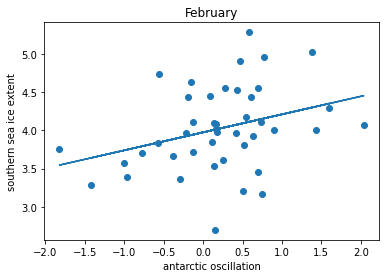

In [19]:
# Doing same month throught the years for South AAO
SIES_extent = np.array(SIE_S['extent'])[2::12]
AAO_flat0 = np.array(AAO_flat)[2::12]
valid = ~(np.isnan(AAO_flat0) | np.isnan(SIES_extent))
m, b, r, p, std_err = stats.linregress(AAO_flat0[valid], SIES_extent[valid])
print('r:', r)
plt.scatter(AAO_flat0, SIES_extent)
plt.plot(AAO_flat0, m*AAO_flat0+b)
plt.xlabel('antarctic oscillation')
plt.ylabel('southern sea ice extent')
plt.title('February')

42.916666666666664
36
36
r: -0.038078397357647925
SEr: 0.26425306846645547


Text(0.5, 1.0, 'yearly mean')

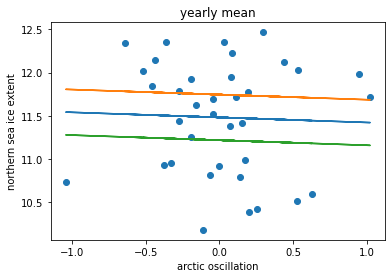

In [20]:
# Looking at mean anomaly per year for AO
# Number of years
print(len(AO_flat)/12)

L=42

AO_Mean=[]
SIEN_extent_Mean=[]
for l in range(0, L):
    SIEN_extent = np.array(SIE_N['extent'])[l*12:(l+1)*12]
    SIEN_extent_mean = np.mean(SIEN_extent)
    AO_flat0 = np.array(AO_flat)[l*12:(l+1)*12]
    AO_mean = np.mean(AO_flat0)
    valid = ~(np.isnan(AO_mean) | np.isnan(SIEN_extent_mean))
    AO_Mean.extend(AO_mean[valid])
    SIEN_extent_Mean.extend(SIEN_extent_mean[valid])
print(len(SIEN_extent_Mean))
print(len(AO_Mean))
m, b, r, p, std_err = stats.linregress(AO_Mean, SIEN_extent_Mean)
print('r:', r)
print('SEr:', std_err)
plt.scatter(AO_Mean, SIEN_extent_Mean)
plt.plot(AO_Mean, m*np.array(AO_Mean)+b)
plt.plot(AO_Mean, m*np.array(AO_Mean)+b+std_err)
plt.plot(AO_Mean, m*np.array(AO_Mean)+b-std_err)
plt.xlabel('arctic oscillation')
plt.ylabel('northern sea ice extent')
plt.title('yearly mean')

r: 0.019887508692913808
SEr: 0.06377954815063207
r: -0.05323946450598359
SEr: 0.06178447395793047
r: -0.16333568213593536
SEr: 0.059550786137771414
r: -0.06684766225473451
SEr: 0.11194736615811662
r: -0.058242921021805893
SEr: 0.10839776474145153
r: 0.03415652840118289
SEr: 0.15538962672045548
r: 0.17459908285096093
SEr: 0.3056806587660773
r: 0.24870085082306007
SEr: 0.302329899515403
r: -0.1237993487125654
SEr: 0.28021896521238504
r: 0.19224171428161613
SEr: 0.21278511639122738
r: -0.03970960450148678
SEr: 0.11916819162823855
r: 0.09570188776277305
SEr: 0.06554535105504815


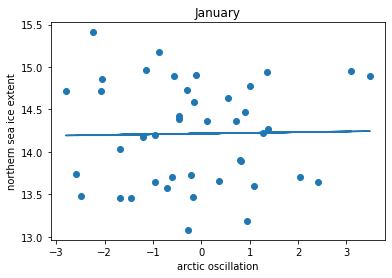

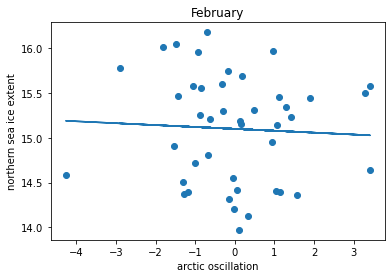

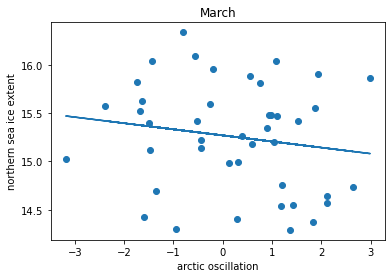

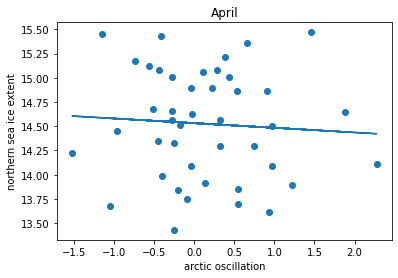

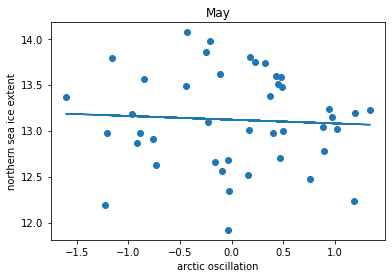

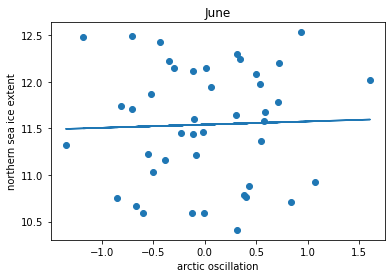

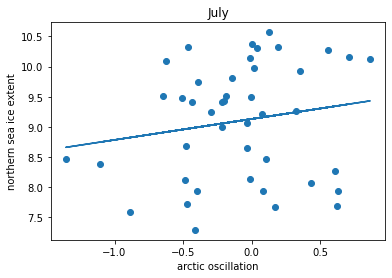

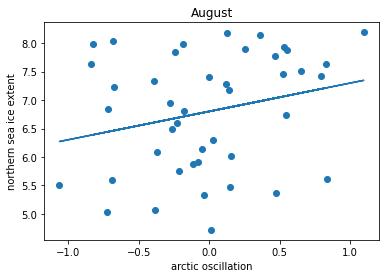

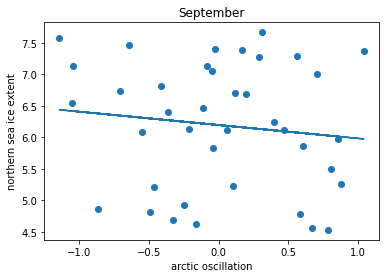

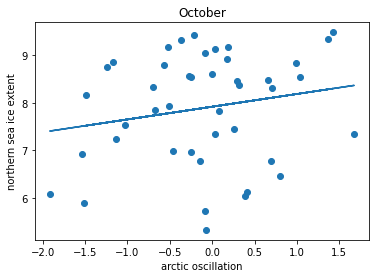

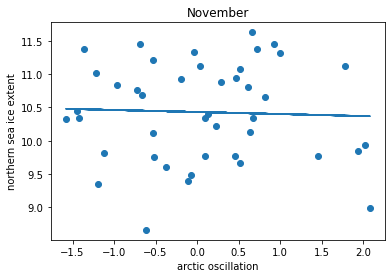

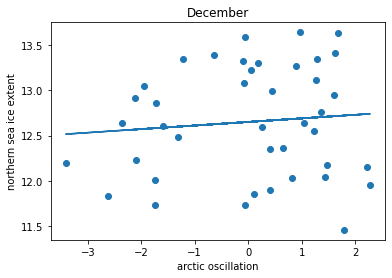

In [21]:
L=12
for l in range(0, L):
    SIEN_extent = np.array(SIE_N['extent'])[l::12]
    AO_flat0 = np.array(AO_flat)[l::12]
    valid = ~(np.isnan(AO_flat0) | np.isnan(SIEN_extent))
    m, b, r, p, std_err = stats.linregress(AO_flat0[valid], SIEN_extent[valid])
    print('r:', r)
    print('SEr:', std_err)
    plt.figure()
    plt.scatter(AO_flat0, SIEN_extent)
    plt.plot(AO_flat0, m*AO_flat0+b)
    plt.xlabel('arctic oscillation')
    plt.ylabel('northern sea ice extent')
    plt.title(month[l+1])

42.916666666666664
36
36
r: 0.36130567078786047
SEr: 0.1413289155055971


Text(0.5, 1.0, 'yearly mean')

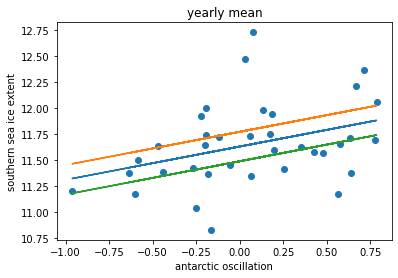

In [22]:
# Looking at mean anomaly per year for AAO
# Number of years
print(len(AAO_flat)/12)

L=42

AAO_Mean=[]
SIES_extent_Mean=[]
for l in range(0, L):
    SIES_extent = np.array(SIE_S['extent'])[l*12:(l+1)*12]
    SIES_extent_mean = np.mean(SIES_extent)
    AAO_flat0 = np.array(AAO_flat)[l*12:+(l+1)*12]
    AAO_mean = np.mean(AAO_flat0)
    valid = ~(np.isnan(AAO_mean) | np.isnan(SIES_extent_mean))
    AAO_Mean.extend(AAO_mean[valid])
    SIES_extent_Mean.extend(SIES_extent_mean[valid])
    
print(len(SIES_extent_Mean))
print(len(AAO_Mean))

m, b, r, p, std_err = stats.linregress(AAO_Mean, SIES_extent_Mean)
print('r:', r)
print('SEr:', std_err)
plt.scatter(AAO_Mean, SIES_extent_Mean)
plt.plot(AAO_Mean, m*np.array(AAO_Mean)+b)
plt.plot(AAO_Mean, m*np.array(AAO_Mean)+b+std_err)
plt.plot(AAO_Mean, m*np.array(AAO_Mean)+b-std_err)
plt.xlabel('antarctic oscillation')
plt.ylabel('southern sea ice extent')
plt.title('yearly mean')

r: 0.17908349174483695
SEr: 0.12175172398592446
r: 0.031825857239698156
SEr: 0.07256218203871223
r: 0.32568932035568554
SEr: 0.10645543956050364
r: 0.43249290411498625
SEr: 0.12269812997271005
r: 0.23744097877313367
SEr: 0.0947382516927524
r: 0.257750710683081
SEr: 0.07921274311750859
r: 0.37310551098774564
SEr: 0.04943087695802978
r: -0.16265519442323462
SEr: 0.06327736292642801
r: -0.4650763037431506
SEr: 0.05597856903535209
r: 0.050062727381072834
SEr: 0.07444026690182268
r: 0.21547123862781106
SEr: 0.07558404290532336
r: 0.4942450476650142
SEr: 0.09216109231843453


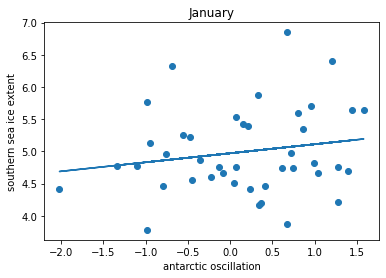

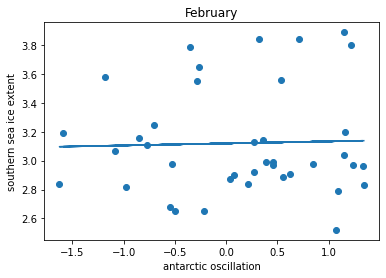

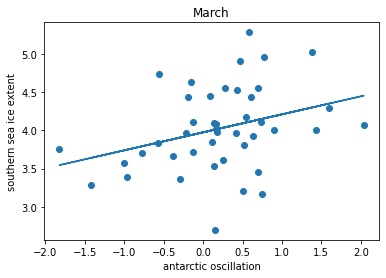

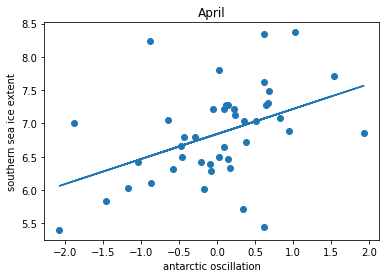

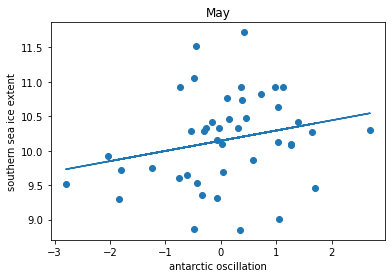

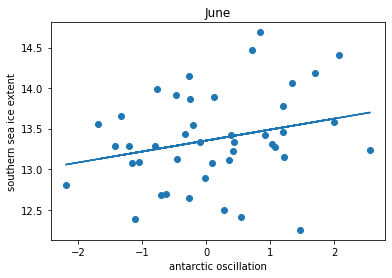

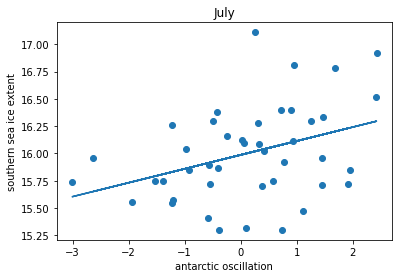

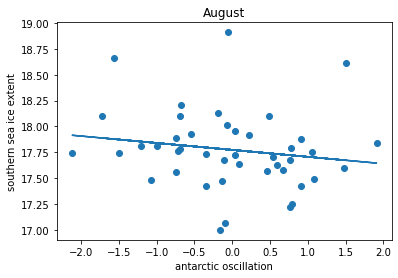

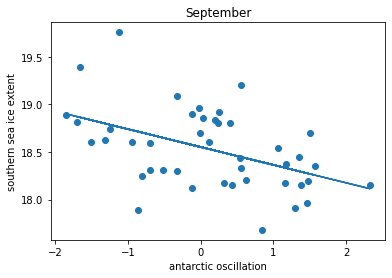

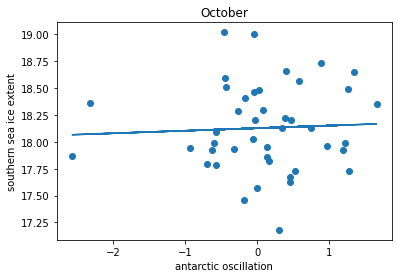

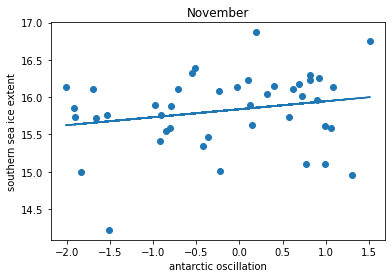

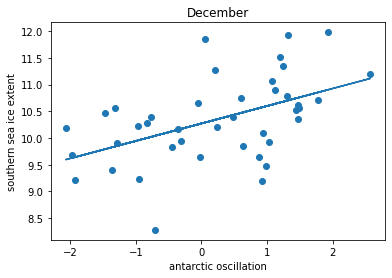

In [23]:
L=12
for l in range(0, L):
    SIES_extent = np.array(SIE_S['extent'])[l::12]
    AAO_flat0 = np.array(AAO_flat)[l::12]
    valid = ~(np.isnan(AAO_flat0) | np.isnan(SIES_extent))
    m, b, r, p, std_err = stats.linregress(AAO_flat0[valid], SIES_extent[valid])
    print('r:', r)
    print('SEr:', std_err)
    plt.figure()
    plt.scatter(AAO_flat0, SIES_extent)
    plt.plot(AAO_flat0, m*AAO_flat0+b)
    plt.xlabel('antarctic oscillation')
    plt.ylabel('southern sea ice extent')
    plt.title(month[l+1])


42.916666666666664
36
36
r: -0.14091705291717627
SEr: 0.07130305660906305


Text(0.5, 1.0, 'AO winter mean against ice extent spring mean')

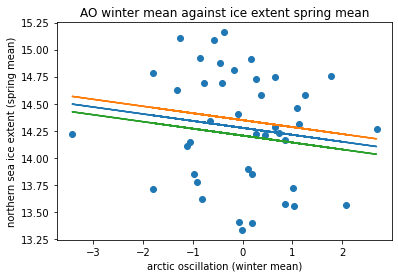

In [24]:
# relation between AO and ice extent in spring afterwards
print(len(AO_flat)/12)

L=42

AO_Mean_winter=[]
SIEN_extent_Mean_spring=[]
for l in range(0, L):
    SIEN_extent_spring = np.array(SIE_N['extent'])[(l+1)*12+2:(l+1)*12+5]
    SIEN_extent_mean_spring = np.mean(SIEN_extent_spring)
    AO_flat_winter = np.array(AO_flat)[l*12+11:(l+1)*12+2]
    AO_mean_winter = np.mean(AO_flat_winter)
    valid = ~(np.isnan(AO_mean_winter) | np.isnan(SIEN_extent_mean_spring))
    AO_Mean_winter.extend(AO_mean_winter[valid])
    SIEN_extent_Mean_spring.extend(SIEN_extent_mean_spring[valid])

print(len(SIES_extent_Mean))
print(len(AAO_Mean))

m, b, r, p, std_err = stats.linregress(AO_Mean_winter, SIEN_extent_Mean_spring)
print('r:', r)
print('SEr:', std_err)
plt.scatter(AO_Mean_winter, SIEN_extent_Mean_spring)
plt.plot(AO_Mean_winter, m*np.array(AO_Mean_winter)+b)
plt.plot(AO_Mean_winter, m*np.array(AO_Mean_winter)+b+std_err)
plt.plot(AO_Mean_winter, m*np.array(AO_Mean_winter)+b-std_err)
plt.xlabel('arctic oscillation (winter mean)')
plt.ylabel('northern sea ice extent (spring mean)')
plt.title('AO winter mean against ice extent spring mean')

In [25]:
# Prepare data for monthly mean values for every same month
#SIE_S['extent'] = SIE_S['extent'].mask(SIE_S['extent'] < SIE_S['extent'].quantile(0.01))
SIES_extent=np.array(SIE_S['extent'])[2::12]
SIEN_extent = np.array(SIE_N['extent'])[2::12]
T_flat0 = np.array(T_flat)[2::12]
AO_flat0 =np.array(AO_flat)[2::12]
AAO_flat0=np.array(AAO_flat)[2::12]
# Covariance matrix and eigenvalues, eigenvectors
labels=['Temperature','SeaIceNorth','SeaIceSouth','AO', 'AAO']
matrix=pd.DataFrame(np.array([T_flat0,SIEN_extent,SIES_extent,AO_flat0, AAO_flat0]),index=labels).transpose()
covmatrix=matrix.corr()
[Eval,Evec]=la.eig(covmatrix)
idx=['ev1={0:.3g}'.format(Eval[0]/5),'ev2={0:.3g}'.format(Eval[1]/5),'ev3={0:.3g}'.format(Eval[2]/5),'ev4={0:.3g}'.format(Eval[3]/5), 'ev5={0:.3g}'.format(Eval[4]/5)]
Evec_df=pd.DataFrame(Evec,index=idx,columns=labels)
print(Eval/5)
print(Evec_df)

[0.40487682 0.04229022 0.25379229 0.17699258 0.12204809]
            Temperature  SeaIceNorth  SeaIceSouth        AO       AAO
ev1=0.405      0.634274    -0.720030    -0.191251 -0.112884 -0.173013
ev2=0.0423    -0.607517    -0.670178     0.127901  0.362835  0.183782
ev3=0.254      0.071678    -0.009954     0.755391  0.155667 -0.632389
ev4=0.177      0.335415     0.177592    -0.157160  0.908947  0.071238
ev5=0.122      0.333134    -0.027923     0.593085 -0.072057  0.728904


In [26]:
# Prepare data for annual mean values 
# Covariance matrix and eigenvalues, eigenvectors
labels=['Temperature','SeaIceNorth','SeaIceSouth','AO', 'AAO']
matrix=pd.DataFrame(np.array([np.array(T_Mean),np.array(SIEN_extent_Mean),np.array(SIES_extent_Mean),np.array(AO_Mean), np.array(AAO_Mean)]),index=labels).transpose()
covmatrix=matrix.corr()
[Eval,Evec]=la.eig(covmatrix)
idx=['ev1={0:.3g}'.format(Eval[0]/5),'ev2={0:.3g}'.format(Eval[1]/5),'ev3={0:.3g}'.format(Eval[2]/5),'ev4={0:.3g}'.format(Eval[3]/5), 'ev5={0:.3g}'.format(Eval[4]/5)]
Evec_df=pd.DataFrame(Evec,index=idx,columns=labels)
print(Eval/5)
print(Evec_df)
# The eigenvalues are approx the same for taking same month values as for taking the annual mean 

[0.45177319 0.01497086 0.22192142 0.18585845 0.12547607]
           Temperature  SeaIceNorth  SeaIceSouth        AO       AAO
ev1=0.452    -0.594464     0.700241     0.336910 -0.201516  0.046450
ev2=0.015     0.607181     0.712995    -0.298951  0.171965 -0.063458
ev3=0.222    -0.393399     0.013620    -0.364356  0.431487 -0.725338
ev4=0.186    -0.085226    -0.000915    -0.601775 -0.785198 -0.118603
ev5=0.125    -0.340467     0.033390    -0.549756  0.356513  0.673523


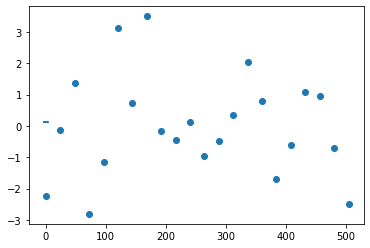

In [27]:
yrs=np.arange(0,len(AO_flat))[0::24]
m, b, r, p, std_err = stats.linregress(yrs, AO_flat[0::24])
plt.figure()
plt.scatter(yrs,AO_flat[0::24])
plt.plot(AO_flat[0::24], m*np.array(AO_flat[0::24])+b)

In [28]:
labels=['Temperature','SeaIceNorth', 'AO']
matrix=pd.DataFrame(np.array([np.array(T_Mean),np.array(SIEN_extent_Mean), np.array(AO_Mean)]),index=labels).transpose()
covmatrix=matrix.corr()
[Eval,Evec]=la.eig(covmatrix)
idx=['ev1={0:.3g}'.format(Eval[0]/3),'ev2={0:.3g}'.format(Eval[1]/3), 'ev3={0:.3g}'.format(Eval[2]/3)]
Evec_df=pd.DataFrame(Evec,index=idx,columns=labels)
print(Eval/3)
print(Evec_df)
labels=['Temperature','SeaIceSouth', 'AAO']
matrix=pd.DataFrame(np.array([np.array(T_Mean),np.array(SIES_extent_Mean), np.array(AAO_Mean)]),index=labels).transpose()
covmatrix=matrix.corr()
[Eval,Evec]=la.eig(covmatrix)
idx=['ev1={0:.3g}'.format(Eval[0]/3),'ev2={0:.3g}'.format(Eval[1]/3), 'ev3={0:.3g}'.format(Eval[2]/3)]
Evec_df=pd.DataFrame(Evec,index=idx,columns=labels)
print(Eval/3)
print(Evec_df)

[0.64216608 0.02540516 0.33242876]
            Temperature  SeaIceNorth        AO
ev1=0.642      0.705994    -0.707027 -0.041055
ev2=0.0254    -0.706142    -0.707176  0.035566
ev3=0.332      0.054179    -0.003882  0.998524
[0.52563367 0.26711016 0.20725617]
           Temperature  SeaIceSouth       AAO
ev1=0.526     0.522548     0.808677  0.270157
ev2=0.267     0.625971    -0.148745 -0.765529
ev3=0.207     0.578881    -0.569136  0.583935


41
41
r: 0.0655008637344907
SEr: 0.08081145080011598
r: -0.7549960634144374
SEr: 0.22774256216772518
r: 0.09841332146560455
SEr: 0.6833880566293883


Text(0.5, 1.0, 'Temperature winter mean against AO winter mean')

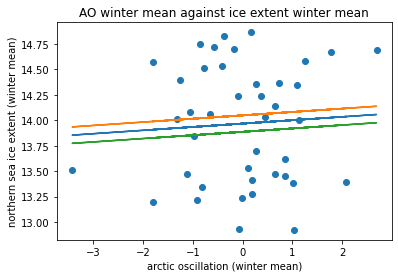

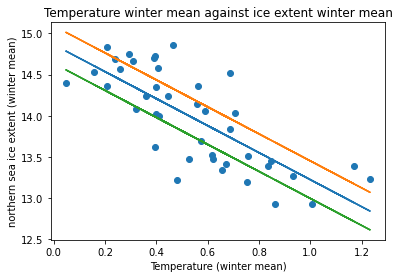

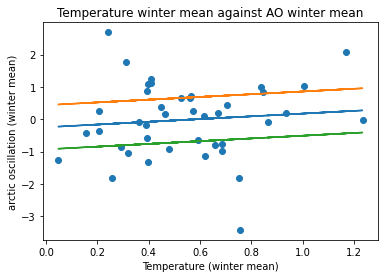

In [63]:
# Winter correlation North

L=42

AO_Mean_winter=[]
SIEN_extent_Mean_winter=[]
T_Mean_winter=[]
for l in range(0, L):
    SIEN_extent_winter = np.array(SIE_N['extent'])[l*12+11:(l+1)*12+2]
    SIEN_extent_mean_winter = np.mean(SIEN_extent_winter)
    AO_flat_winter = np.array(AO_flat)[l*12+11:(l+1)*12+2]
    AO_mean_winter = np.mean(AO_flat_winter)
    T_flat0_winter = np.array(T_flat)[l*12+11:(l+1)*12+2]
    T_mean_winter = np.mean(T_flat0_winter)
    valid = ~((np.isnan(AO_mean_winter) or np.isnan(SIEN_extent_mean_winter))or(np.isnan(T_mean_winter)))
    AO_Mean_winter.extend(AO_mean_winter[valid])
    SIEN_extent_Mean_winter.extend(SIEN_extent_mean_winter[valid])
    T_Mean_winter.extend(T_mean_winter[valid])

print(len(SIEN_extent_Mean_winter))
print(len(AO_Mean_winter))

m, b, r, p, std_err = stats.linregress(AO_Mean_winter, SIEN_extent_Mean_winter)
print('r:', r)
print('SEr:', std_err)
plot1 = plt. figure(1)
plt.scatter(AO_Mean_winter, SIEN_extent_Mean_winter)
plt.plot(AO_Mean_winter, m*np.array(AO_Mean_winter)+b)
plt.plot(AO_Mean_winter, m*np.array(AO_Mean_winter)+b+std_err)
plt.plot(AO_Mean_winter, m*np.array(AO_Mean_winter)+b-std_err)
plt.xlabel('AO (winter mean)')
plt.ylabel('Northern sea ice extent (winter mean)')
plt.title('AO against ice extent (winter mean)')

m, b, r, p, std_err = stats.linregress(T_Mean_winter, SIEN_extent_Mean_winter)
print('r:', r)
print('SEr:', std_err)
plot1 = plt. figure(2)
plt.scatter(T_Mean_winter, SIEN_extent_Mean_winter)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b+std_err)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b-std_err)
plt.xlabel('Temperature (winter mean)')
plt.ylabel('Northern sea ice extent (winter mean)')
plt.title('Temperature against ice extent (winter mean)')

m, b, r, p, std_err = stats.linregress(T_Mean_winter, AO_Mean_winter)
print('r:', r)
print('SEr:', std_err)
plot1 = plt. figure(3)
plt.scatter(T_Mean_winter, AO_Mean_winter)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b+std_err)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b-std_err)
plt.xlabel('Temperature (winter mean)')
plt.ylabel('AO (winter mean)')
plt.title('Temperature against AO (winter mean)')

In [43]:
labels=['Temperature','SeaIceNorth', 'AO']
matrix=pd.DataFrame(np.array([np.array(T_Mean_winter),np.array(SIEN_extent_Mean_winter), np.array(AO_Mean_winter)]),index=labels).transpose()
covmatrix=matrix.corr()
[Eval,Evec]=la.eig(covmatrix)
idx=['ev1={0:.3g}'.format(Eval[0]/3),'ev2={0:.3g}'.format(Eval[1]/3), 'ev3={0:.3g}'.format(Eval[2]/3)]
Evec_df=pd.DataFrame(Evec,index=idx,columns=labels)
print(Eval/3)
print(Evec_df)

[0.07586781 0.58524043 0.33889177]
            Temperature  SeaIceNorth        AO
ev1=0.0759    -0.700868    -0.708451  0.082947
ev2=0.585     -0.697669     0.705072  0.127009
ev3=0.339      0.148464    -0.031147  0.988427


42
42
r: -0.25884322363431267
SEr: 0.08972468478186127
r: 0.29304446309152526
SEr: 0.21533796835895777
r: -0.014010211581525144
SEr: 0.38333116824889973


Text(0.5, 1.0, 'Temperature against AAO (winter mean)')

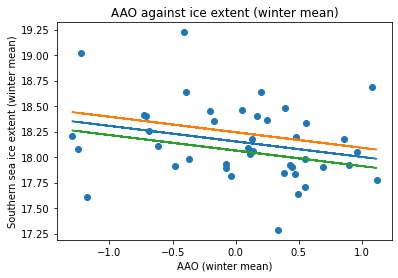

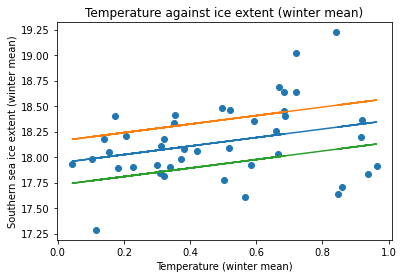

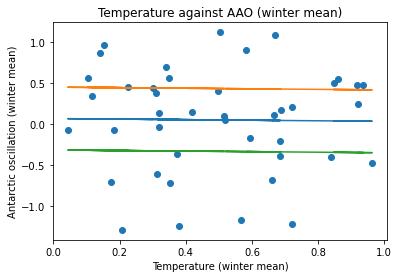

In [65]:
# Winter correlation South

L=42

AAO_Mean_winter=[]
SIES_extent_Mean_winter=[]
T_Mean_winter=[]
for l in range(0, L):
    SIES_extent_winter = np.array(SIE_S['extent'])[l*12+7:l*12+10]
    SIES_extent_mean_winter = np.mean(SIES_extent_winter)
    AAO_flat_winter = np.array(AAO_flat)[l*12+7:l*12+10]
    AAO_mean_winter = np.mean(AAO_flat_winter)
    T_flat0_winter = np.array(T_flat)[l*12+7:l*12+10]
    T_mean_winter = np.mean(T_flat0_winter)
    valid = ~((np.isnan(AAO_mean_winter) or np.isnan(SIES_extent_mean_winter))or(np.isnan(T_mean_winter)))
    AAO_Mean_winter.extend(AAO_mean_winter[valid])
    SIES_extent_Mean_winter.extend(SIES_extent_mean_winter[valid])
    T_Mean_winter.extend(T_mean_winter[valid])

print(len(SIES_extent_Mean_winter))
print(len(AAO_Mean_winter))

m, b, r, p, std_err = stats.linregress(AAO_Mean_winter, SIES_extent_Mean_winter)
print('r:', r)
print('SEr:', std_err)
plot1 = plt. figure(1)
plt.scatter(AAO_Mean_winter, SIES_extent_Mean_winter)
plt.plot(AAO_Mean_winter, m*np.array(AAO_Mean_winter)+b)
plt.plot(AAO_Mean_winter, m*np.array(AAO_Mean_winter)+b+std_err)
plt.plot(AAO_Mean_winter, m*np.array(AAO_Mean_winter)+b-std_err)
plt.xlabel('AAO (winter mean)')
plt.ylabel('Southern sea ice extent (winter mean)')
plt.title('AAO against ice extent (winter mean)')

m, b, r, p, std_err = stats.linregress(T_Mean_winter, SIES_extent_Mean_winter)
print('r:', r)
print('SEr:', std_err)
plot1 = plt. figure(2)
plt.scatter(T_Mean_winter, SIES_extent_Mean_winter)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b+std_err)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b-std_err)
plt.xlabel('Temperature (winter mean)')
plt.ylabel('Southern sea ice extent (winter mean)')
plt.title('Temperature against ice extent (winter mean)')

m, b, r, p, std_err = stats.linregress(T_Mean_winter, AAO_Mean_winter)
print('r:', r)
print('SEr:', std_err)
plot1 = plt. figure(3)
plt.scatter(T_Mean_winter, AAO_Mean_winter)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b+std_err)
plt.plot(T_Mean_winter, m*np.array(T_Mean_winter)+b-std_err)
plt.xlabel('Temperature (winter mean)')
plt.ylabel('Antarctic oscillation (winter mean)')
plt.title('Temperature against AAO (winter mean)')

In [52]:
labels=['Temperature','SeaIceSouth', 'AAO']
matrix=pd.DataFrame(np.array([np.array(T_Mean_winter),np.array(SIES_extent_Mean_winter), np.array(AAO_Mean_winter)]),index=labels).transpose()
covmatrix=matrix.corr()
[Eval,Evec]=la.eig(covmatrix)
idx=['ev1={0:.3g}'.format(Eval[0]/3),'ev2={0:.3g}'.format(Eval[1]/3), 'ev3={0:.3g}'.format(Eval[2]/3)]
Evec_df=pd.DataFrame(Evec,index=idx,columns=labels)
print(Eval/3)
print(Evec_df)

[0.46600305 0.32869909 0.20529786]
           Temperature  SeaIceSouth       AAO
ev1=0.466    -0.532676    -0.661892 -0.527405
ev2=0.329    -0.700787    -0.004435  0.713357
ev3=0.205     0.474504    -0.749586  0.461483


In [62]:
# Prepare data for annual mean values
AAO_Mean_winter_5=[]
SIES_extent_Mean_winter_5=[]
AO_Mean_winter_5=[]
SIEN_extent_Mean_winter_5=[]
T_Mean_5=[]
for l in range(0, L):
    SIES_extent_winter = np.array(SIE_S['extent'])[l*12+7:l*12+10]
    SIES_extent_mean_winter = np.mean(SIES_extent_winter)
    AAO_flat_winter = np.array(AAO_flat)[l*12+7:l*12+10]
    AAO_mean_winter = np.mean(AAO_flat_winter)
    SIEN_extent_winter = np.array(SIE_N['extent'])[l*12+11:(l+1)*12+2]
    SIEN_extent_mean_winter = np.mean(SIEN_extent_winter)
    AO_flat_winter = np.array(AO_flat)[l*12+11:(l+1)*12+2]
    AO_mean_winter = np.mean(AO_flat_winter)
    T_flat0_winter = np.array(T_flat)[l*12:(l+1)*12]
    T_mean_winter = np.mean(T_flat0_winter)
    valid_5 = ~((np.isnan(AAO_mean_winter) or np.isnan(SIES_extent_mean_winter))or(np.isnan(AO_mean_winter) or np.isnan(SIEN_extent_mean_winter))or(np.isnan(T_mean_winter)))
    AO_Mean_winter_5.extend(AO_mean_winter[valid_5])
    SIEN_extent_Mean_winter_5.extend(SIEN_extent_mean_winter[valid_5])
    AAO_Mean_winter_5.extend(AAO_mean_winter[valid_5])
    SIES_extent_Mean_winter_5.extend(SIES_extent_mean_winter[valid_5])
    T_Mean_5.extend(T_mean_winter[valid_5])

# Covariance matrix and eigenvalues, eigenvectors
labels=['Temperature','SeaIceNorth','SeaIceSouth','AO', 'AAO']
matrix_5=pd.DataFrame(np.array([np.array(T_Mean_5),np.array(SIEN_extent_Mean_winter_5),np.array(SIES_extent_Mean_winter_5),np.array(AO_Mean_winter_5), np.array(AAO_Mean_winter_5)]),index=labels).transpose()
covmatrix_5=matrix_5.corr()
[Eval,Evec]=la.eig(covmatrix_5)
idx=['ev1={0:.3g}'.format(Eval[0]/5),'ev2={0:.3g}'.format(Eval[1]/5),'ev3={0:.3g}'.format(Eval[2]/5),'ev4={0:.3g}'.format(Eval[3]/5), 'ev5={0:.3g}'.format(Eval[4]/5)]
Evec_df=pd.DataFrame(Evec,index=idx,columns=labels)
print(Eval/5)
print(Evec_df)
# The eigenvalues are approx the same for taking same month values as for taking the annual mean

[0.41267066 0.01321486 0.11852356 0.20571414 0.24987677]
            Temperature  SeaIceNorth  SeaIceSouth        AO       AAO
ev1=0.413      0.650102    -0.676278     0.246607 -0.235660  0.060530
ev2=0.0132    -0.671548    -0.718390    -0.075932  0.094946 -0.134754
ev3=0.119      0.353359    -0.115618    -0.646396  0.524673 -0.410684
ev4=0.206     -0.039014     0.055745    -0.400848 -0.800273 -0.440743
ev5=0.25      -0.002449    -0.100440    -0.595745 -0.140468  0.784387
